# **Convolutional Neural Networks (CNNs) for Image Classification**

In [1]:
# Pytorch functions
import torch
# Neural network layers
import torch.nn as nn
import torch.nn.functional as F
# Optimizer
import torch.optim as optim
# Handling dataset|
import torch.utils.data as data
# Torchvision library
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import os
import cv2
# For results
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
image = torch.randn((1, 1, 28, 28)) # [batch_size, n_channels, height, width]
print(f"Image size: {image.shape}")

Image size: torch.Size([1, 1, 28, 28])


# Convolutional and Max-Pooling layers

  *  torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
  *  torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')


In [4]:
max_pool = nn.MaxPool2d(kernel_size = 2)
img_max_pool = max_pool(image)

print(f"2D Max Pooling Output size: {img_max_pool.shape}")

2D Max Pooling Output size: torch.Size([1, 1, 14, 14])


In [5]:
conv_2d = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3)
img_conv_2d = conv_2d(image)

print(f"2D Conv Output size: {img_conv_2d.shape}")

2D Conv Output size: torch.Size([1, 64, 26, 26])


In [6]:
print(conv_2d.weight.data.shape)
# Select first filter
print(conv_2d.weight.data[0][0])

torch.Size([64, 1, 3, 3])
tensor([[ 0.1717, -0.3001,  0.1632],
        [-0.2408, -0.2233, -0.2340],
        [-0.1544, -0.2994,  0.2847]])


In [7]:
# Define an identity kernel
f = torch.FloatTensor([[0, 0, 0],
                  [0, 1, 0],
                  [0, 0, 0]])

conv_2d.weight.data[0][0] = f

print(conv_2d.weight.data[0][0])

tensor([[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]])


In [8]:
# Load MNIST dataset
# Available datasets at https://pytorch.org/vision/stable/datasets.html
ROOT = './data'
train_data = torchvision.datasets.MNIST(root=ROOT, train=True, download=True)

In [9]:
# Select 1st image
min_px_value = train_data.data[0].min()
print(f"Minimum pixel value : {min_px_value}")
max_px_value = train_data.data[0].max()
print(f"Maximum pixel value : {max_px_value}")

Minimum pixel value : 0
Maximum pixel value : 255


In [10]:
# Data normalization
# Mean and std should be divided by 255 (maximum pixel value)
# because, after the ToTensor() transformation (see next step), images are normalized
# between 0 and 1.

train_mean = train_data.data.float().mean() / 255
train_std = train_data.data.float().std() / 255

print("-----  TRAIN NORMALIZATION VALUES  -----")
print(f"Mean: {train_mean:.4f}")
print(f"Standard Deviation: {train_std:.4f}")

-----  TRAIN NORMALIZATION VALUES  -----
Mean: 0.1307
Standard Deviation: 0.3081


In [11]:
# Compositions of transformations
train_transforms = torchvision.transforms.Compose([
                                                   torchvision.transforms.ToTensor(), # values are normalized between 0 and 1
                                                   torchvision.transforms.Normalize(train_mean, train_std)
])

test_transforms = torchvision.transforms.Compose([
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(train_mean, train_std)
])

In [12]:
# Load data with transformations
train_data = torchvision.datasets.MNIST(root=ROOT,
                                        train=True,
                                        download=True,
                                        transform=train_transforms)

test_data = torchvision.datasets.MNIST(root=ROOT,
                                        train=False,
                                        download=True,
                                        transform=test_transforms)
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.13066048920154572, std=0.30810779333114624)
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.13066048920154572, std=0.30810779333114624)
           )


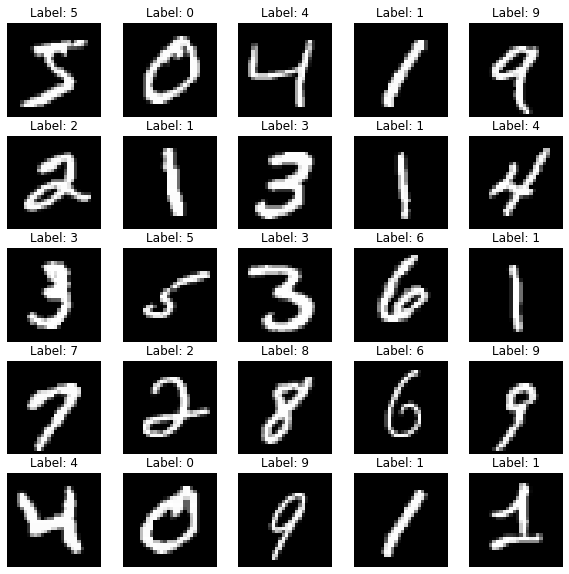

In [13]:
# Plot some training images
N_IMAGES = 25
plt.figure(figsize=(10, 10))
for i in range(N_IMAGES):
  img = train_data.data[i] # Unnormalized images
  label = train_data[i][1]
  plt.subplot(5,5,i+1), plt.imshow(img, cmap='gray'), plt.title(f"Label: {label}"), plt.axis('off')

In [14]:
def create_validation_set(train_data, train_percentage, test_transforms):
    
  # Split train data into train and validation sets
  # (10% of training set will be used as validation set)
  num_train_examples = int(len(train_data) * train_percentage)
  num_valid_examples = len(train_data) - num_train_examples

  # Create 'Subset' objects
  train_data, valid_data = data.random_split(train_data, [num_train_examples, num_valid_examples])

  print(f"Number training examples: {len(train_data)}")
  print(f"Number validation examples: {len(valid_data)}")

  # Apply test transformations to the validation set
  valid_data = copy.deepcopy(valid_data) # If we change train transformations, this won't affect the validation set
  valid_data.dataset.transform = test_transforms

  return valid_data

In [15]:
valid_data = create_validation_set(train_data, 0.8, test_transforms)

Number training examples: 48000
Number validation examples: 12000


In [16]:
# Create iterators
BATCH_SIZE = 64

train_iterator = torch.utils.data.DataLoader(train_data, 
                                             shuffle=True, 
                                             batch_size=BATCH_SIZE)

valid_iterator = torch.utils.data.DataLoader(valid_data, 
                                             batch_size=BATCH_SIZE)

test_iterator = torch.utils.data.DataLoader(test_data, 
                                            batch_size=BATCH_SIZE)

# **Ex.1**

Define a 3x3 Sobel filter to compute both vertical and horizontal derivative approximations, select the first 5 images of the MNIST test set and plot input and filtered images. Input and filtered images should have the same size.

In [ ]:
#####################################
#                                   #
#       WRITE YOUR CODE HERE        #
#                                   #
#####################################

Output x_sobel

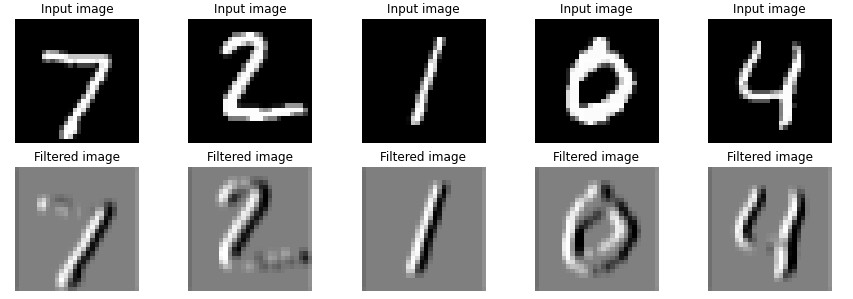


Output y_sobel

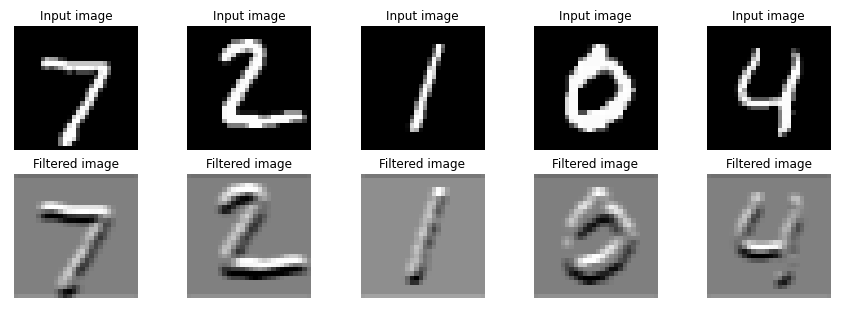

# **Ex.2** 

Implement the LeNet architecture to classify handwritten digits. Compared to the original architecture, we will use 28x28 (instead of 32x32) input images and a standard linear layer as output layer (we will not use Gaussian connections). 

	• INPUT: 28x28 grayscale image;
	• LAYER 1: Convolutional layer with 6 convolutional filters (select a padding value such that the output is a 28x28 feature map);
	• LAYER 2: A max pooling layer that down-samples Layer 1. Pass the output of Layer 2 through a ReLU activation function;
	• LAYER 3: Convolutional layer with 16 convolutional filters;
	• LAYER 4: A max pooling layer that down-samples Layer 3. Pass the output of Layer 4 through a ReLU activation function;
	• FLATTEN: Flatten the image to put it through linear layers; 
	• LAYER 5: Linear layer (ouput dim = 120). Pass the output of Layer 5 through a ReLU activation function;
	• LAYER 6: Linear layer (ouput dim = 84). Pass the output of Layer 6 through a ReLU activation function;
	• LAYER 7: Linear layer (ouput dim = 10)

You can infer the kernel size of each convolutional layer from the image below.
	
**Ex.2.1** - Compute the number of parameters for each layer of the previous network.

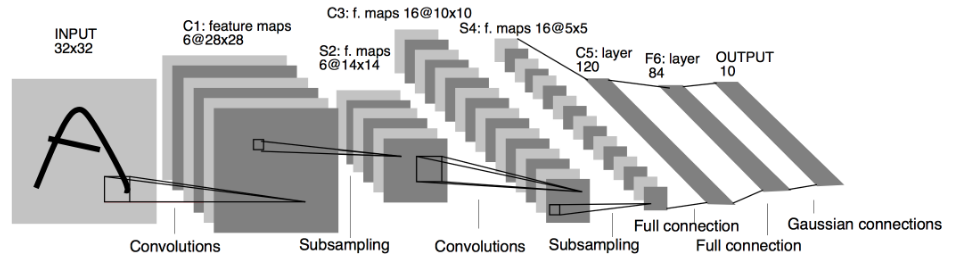

In [24]:
#####################################
#                                   #
#       WRITE YOUR CODE HERE        #
#                                   #
#####################################

In [25]:
OUTPUT_DIM = 10
model = LeNet(OUTPUT_DIM)

In [27]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters.")

The model has 61,706 trainable parameters.


In [28]:
# Loss
criterion = nn.CrossEntropyLoss() # Softmax + CrossEntropy

# Put model&criterion on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = criterion.to(device)

In [29]:
# Optim
optimizer = optim.SGD(model.parameters(), lr=5e-4)

model = model.to(device)

* Training phase

In [30]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  # Train mode
  model.train()

  for (x,y) in iterator:
    x = x.to(device)
    y = y.to(device)
    # Set gradients to zero
    optimizer.zero_grad()
    
    # Make Predictions
    y_pred = model(x)

    # Compute loss
    loss = criterion(y_pred, y)
    
    # Compute accuracy
    acc = calculate_accuracy(y_pred, y)

    # Backprop
    loss.backward()

    # Apply optimizer
    optimizer.step()

    # Extract data from loss and accuracy
    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

* Validation/Testing phase

In [31]:
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  # Evaluation mode
  model.eval()

  # Do not compute gradients
  with torch.no_grad():

    for(x,y) in iterator:

      x = x.to(device)
      y = y.to(device)
      
      # Make Predictions
      y_pred = model(x)

      # Compute loss
      loss = criterion(y_pred, y)
      
      # Compute accuracy
      acc = calculate_accuracy(y_pred, y)

      # Extract data from loss and accuracy
      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [32]:
def calculate_accuracy(y_pred, y):
  '''
  Compute accuracy from ground-truth and predicted labels.
  
  Input
  ------
  y_pred: torch.Tensor [BATCH_SIZE, N_LABELS]
  y: torch.Tensor [BATCH_SIZE]

  Output
  ------
  acc: float
    Accuracy
  '''
  y_prob = F.softmax(y_pred, dim = -1)
  y_pred = y_pred.argmax(dim=1, keepdim = True)
  correct = y_pred.eq(y.view_as(y_pred)).sum()
  acc = correct.float()/y.shape[0]
  return acc

In [33]:
def model_training(n_epochs, model, train_iterator, valid_iterator, optimizer, criterion, device, model_name='best_model.pt'):

  # Initialize validation loss
  best_valid_loss = float('inf')

  # Save output losses, accs
  train_losses = []
  train_accs = []
  valid_losses = []
  valid_accs = []

  # Loop over epochs
  for epoch in range(n_epochs):
    start_time = time.time()
    # Train
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    # Validation
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    # Save best model
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      # Save model
      torch.save(model.state_dict(), model_name)
    end_time = time.time()
    
    print(f"\nEpoch: {epoch+1}/{n_epochs} -- Epoch Time: {end_time-start_time:.2f} s")
    print("---------------------------------")
    print(f"Train -- Loss: {train_loss:.3f}, Acc: {train_acc * 100:.2f}%")
    print(f"Val -- Loss: {valid_loss:.3f}, Acc: {valid_acc * 100:.2f}%")

    # Save
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

  return train_losses, train_accs, valid_losses, valid_accs

In [34]:
N_EPOCHS = 30
train_losses, train_accs, valid_losses, valid_accs = model_training(N_EPOCHS, 
                                                                    model, 
                                                                    train_iterator, 
                                                                    valid_iterator, 
                                                                    optimizer, 
                                                                    criterion, 
                                                                    device,
                                                                    'lenet.pt')


Epoch: 1/30 -- Epoch Time: 8.85 s
---------------------------------
Train -- Loss: 2.298, Acc: 11.25%
Val -- Loss: 2.296, Acc: 11.05%

Epoch: 2/30 -- Epoch Time: 8.57 s
---------------------------------
Train -- Loss: 2.292, Acc: 11.74%
Val -- Loss: 2.290, Acc: 12.42%

Epoch: 3/30 -- Epoch Time: 8.86 s
---------------------------------
Train -- Loss: 2.286, Acc: 15.04%
Val -- Loss: 2.282, Acc: 17.64%

Epoch: 4/30 -- Epoch Time: 8.87 s
---------------------------------
Train -- Loss: 2.277, Acc: 19.69%
Val -- Loss: 2.272, Acc: 21.28%

Epoch: 5/30 -- Epoch Time: 8.86 s
---------------------------------
Train -- Loss: 2.264, Acc: 24.49%
Val -- Loss: 2.256, Acc: 27.30%

Epoch: 6/30 -- Epoch Time: 8.89 s
---------------------------------
Train -- Loss: 2.244, Acc: 31.75%
Val -- Loss: 2.231, Acc: 34.23%

Epoch: 7/30 -- Epoch Time: 8.87 s
---------------------------------
Train -- Loss: 2.207, Acc: 36.67%
Val -- Loss: 2.180, Acc: 37.89%

Epoch: 8/30 -- Epoch Time: 9.00 s
--------------------

In [35]:
def plot_results(n_epochs, train_losses, train_accs, valid_losses, valid_accs):
  N_EPOCHS = n_epochs
  # Plot results
  plt.figure(figsize=(20, 6))
  _ = plt.subplot(1,2,1)
  plt.plot(np.arange(N_EPOCHS)+1, train_losses, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, valid_losses, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')

  _ = plt.subplot(1,2,2)
  plt.plot(np.arange(N_EPOCHS)+1, train_accs, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, valid_accs, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')

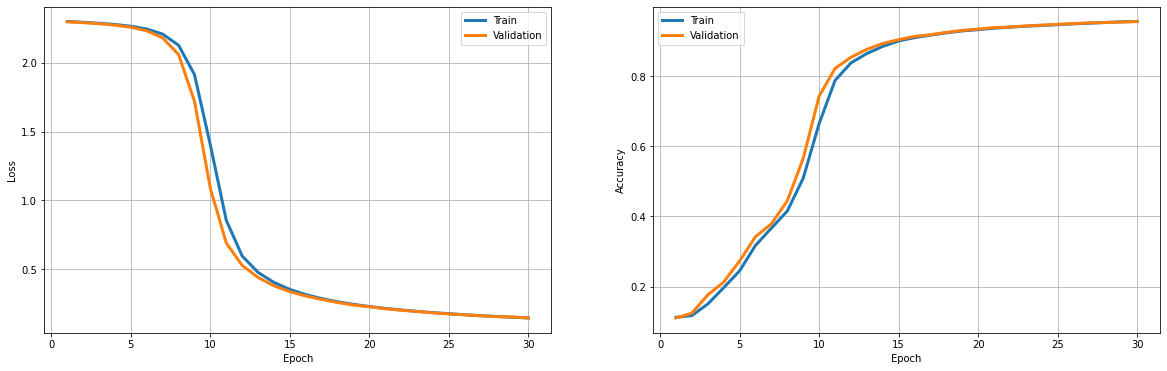

In [36]:
plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

In [37]:
def model_testing(model, test_iterator, criterion, device, model_name='best_model.pt'):
  # Test model
  model.load_state_dict(torch.load(model_name))
  test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
  print(f"Test -- Loss: {test_loss:.3f}, Acc: {test_acc * 100:.2f} %")

In [38]:
model_testing(model, test_iterator, criterion, device, 'lenet.pt')

Test -- Loss: 0.131, Acc: 95.99 %


In [39]:
def predict(model, iterator, device):
  
  # Evaluation mode
  model.eval()
  
  labels = []
  pred = []

  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y_pred = model(x)

      # Get label with highest score
      y_prob = F.softmax(y_pred, dim = -1)
      top_pred = y_prob.argmax(1, keepdim=True)

      labels.append(y.cpu())
      pred.append(top_pred.cpu())

  labels = torch.cat(labels, dim=0)
  pred = torch.cat(pred, dim=0)
  
  return labels, pred


In [40]:
def print_report(model, test_iterator, device):
  labels, pred = predict(model, test_iterator, device)
  print(confusion_matrix(labels, pred))
  print("\n")
  print(classification_report(labels, pred))

In [41]:
print_report(model, test_iterator, device)

[[ 965    0    2    0    0    1    5    2    5    0]
 [   0 1114    3    2    0    1    2    0   13    0]
 [  12    1  969    8    3    0    4   16   18    1]
 [   1    1    2  972    0    8    0    9   14    3]
 [   1    2    3    0  942    0    4    0    4   26]
 [   6    1    0   15    0  855    3    2    5    5]
 [  10    3    1    0    8    5  928    0    3    0]
 [   1    5   18    6    1    0    0  970    3   24]
 [   7    3    5    5    3    1    5   10  925   10]
 [   5    7    2    8   12    5    0    7    6  957]]


              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.96      0.94      0.95      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.96      0.97       982
           5       0.98      0.96      0.97       892
           6       0.98      0.97      0.97       958
           7       0.95      0.94 

# **Ex. 3**

Visualize filters and feature maps.

Select the first 5 test images and the first CONV layer, and plot the filters and the output of the convolution between each image and each filter (feature maps).

In [ ]:
#####################################
#                                   #
#       WRITE YOUR CODE HERE        #
#                                   #
#####################################

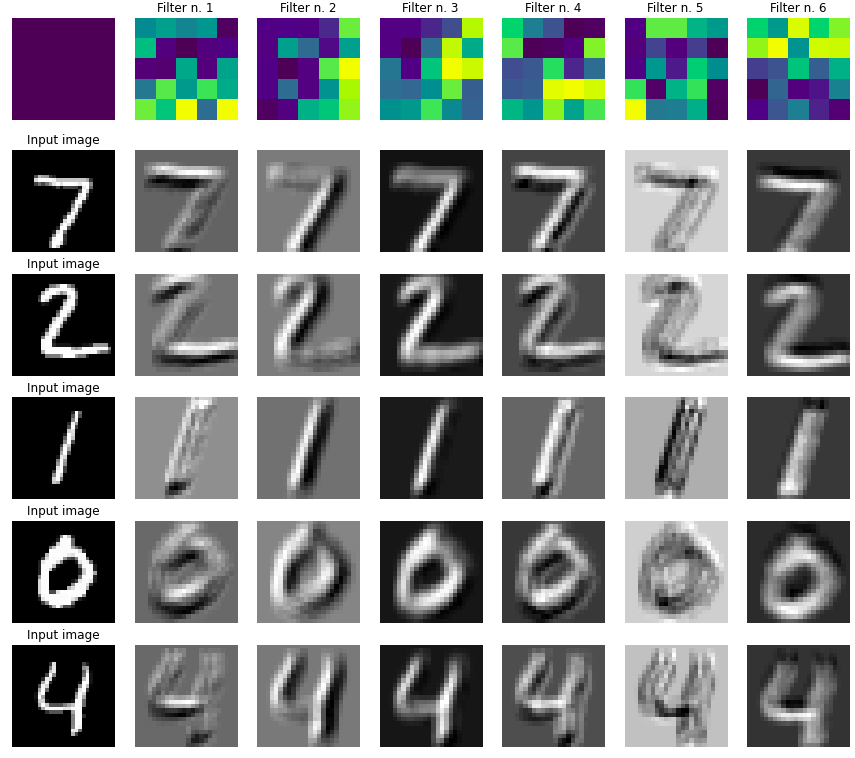

# Import a convolutional neural network

*  Load CIFAR10 dataset;
*  Import VGG16 architecure;
*  Train VGG16 on CIFAR 10 from scratch.

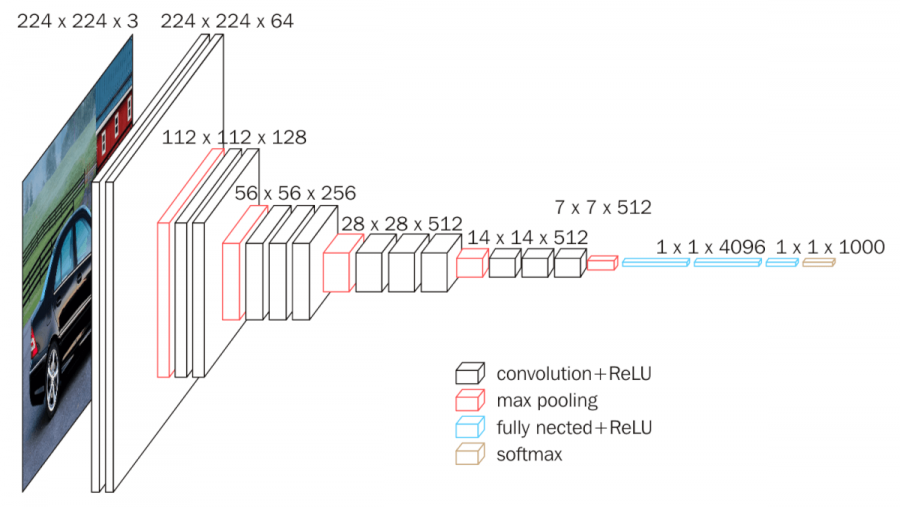

In [43]:
# Load CIFAR10 dataset
# Available datasets at https://pytorch.org/vision/stable/datasets.html
ROOT = './data'
train_data = torchvision.datasets.CIFAR10(root=ROOT, train=True, download=True)

# You can also use the 'transform' argument to specify transformations to apply to the dataset
# e.g. 'train_data = torchvision.datasets.CIFAR10(root=ROOT, train=True, download=True, transform=...)'
# See the next steps for applying transformations to a dataset.

Files already downloaded and verified


In [44]:
# -----  TRAIN NORMALIZATION VALUES  -----
# Refer to the previous lab to compute mean and std.
train_mean =  [0.49139968, 0.48215841, 0.44653091]
train_std = [0.24703223, 0.24348513, 0.26158784]

In [45]:
# Compositions of transformations
train_transforms = torchvision.transforms.Compose([
#                                                   torchvision.transforms.Resize((224,224)),
                                                   torchvision.transforms.RandomCrop(32,5),
                                                   torchvision.transforms.ToTensor(), # values are normalized between 0 and 1
                                                   torchvision.transforms.Normalize(train_mean, train_std)
])

test_transforms = torchvision.transforms.Compose([
#                                                  torchvision.transforms.Resize((224,224)),                                                  
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(train_mean, train_std)
])

In [46]:
# Load data with transformations
train_data = torchvision.datasets.CIFAR10(root=ROOT,
                                        train=True,
                                        download=True,
                                        transform=train_transforms)

test_data = torchvision.datasets.CIFAR10(root=ROOT,
                                        train=False,
                                        download=True,
                                        transform=test_transforms)
print(train_data)
print(test_data)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=5)
               ToTensor()
               Normalize(mean=[0.49139968, 0.48215841, 0.44653091], std=[0.24703223, 0.24348513, 0.26158784])
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.49139968, 0.48215841, 0.44653091], std=[0.24703223, 0.24348513, 0.26158784])
           )


In [47]:
valid_data = create_validation_set(train_data, 0.8, test_transforms)

Number training examples: 40000
Number validation examples: 10000


In [48]:
# Create iterators
BATCH_SIZE = 128

train_iterator = torch.utils.data.DataLoader(train_data, 
                                             shuffle=True, 
                                             batch_size=BATCH_SIZE)

valid_iterator = torch.utils.data.DataLoader(valid_data, 
                                             batch_size=BATCH_SIZE)

test_iterator = torch.utils.data.DataLoader(test_data, 
                                            batch_size=BATCH_SIZE)

In [49]:
%%capture
vgg16 = torchvision.models.vgg16(pretrained = False)

In [50]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

*  Let's modify the 'classifier' section of the VGG16 network since out dataset contains 10 classes.

In [51]:
print(vgg16.classifier[-1])
print(f"Input features: {vgg16.classifier[-1].in_features}")
print(f"Output features: {vgg16.classifier[-1].out_features}")

Linear(in_features=4096, out_features=1000, bias=True)
Input features: 4096
Output features: 1000


In [52]:
print(f'The model has {count_parameters(vgg16):,} trainable parameters')

The model has 138,357,544 trainable parameters


In [53]:
for p in vgg16.classifier[-1].parameters():
  print(p.shape)

torch.Size([1000, 4096])
torch.Size([1000])


In [54]:
OUTPUT_DIM = 10
vgg16.classifier[-1] = nn.Linear(vgg16.classifier[-1].in_features, OUTPUT_DIM)

In [55]:
print(vgg16.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)


In [56]:
print(f'The model has {count_parameters(vgg16):,} trainable parameters')

The model has 134,301,514 trainable parameters


In [57]:
for p in vgg16.classifier[-1].parameters():
  print(p.shape)

torch.Size([10, 4096])
torch.Size([10])


In [58]:
# Optim
optimizer = optim.Adam(vgg16.parameters(), lr=1e-4)

vgg16 = vgg16.to(device)

In [59]:
N_EPOCHS = 30
train_losses_vgg16_scratch, train_accs_vgg16_scratch, valid_losses_vgg16_scratch, valid_accs_vgg16_scratch = model_training(N_EPOCHS, 
                                                                                                                            vgg16,
                                                                                                                            train_iterator,
                                                                                                                            valid_iterator,
                                                                                                                            optimizer,
                                                                                                                            criterion,
                                                                                                                            device,
                                                                                                                            'vgg16.pt') 


Epoch: 1/30 -- Epoch Time: 54.14 s
---------------------------------
Train -- Loss: 1.908, Acc: 24.77%
Val -- Loss: 1.568, Acc: 39.95%

Epoch: 2/30 -- Epoch Time: 55.60 s
---------------------------------
Train -- Loss: 1.534, Acc: 41.76%
Val -- Loss: 1.307, Acc: 50.73%

Epoch: 3/30 -- Epoch Time: 58.18 s
---------------------------------
Train -- Loss: 1.289, Acc: 52.67%
Val -- Loss: 1.156, Acc: 57.76%

Epoch: 4/30 -- Epoch Time: 58.21 s
---------------------------------
Train -- Loss: 1.136, Acc: 59.08%
Val -- Loss: 0.953, Acc: 65.71%

Epoch: 5/30 -- Epoch Time: 57.03 s
---------------------------------
Train -- Loss: 1.015, Acc: 63.89%
Val -- Loss: 0.897, Acc: 67.99%

Epoch: 6/30 -- Epoch Time: 57.34 s
---------------------------------
Train -- Loss: 0.914, Acc: 67.89%
Val -- Loss: 0.773, Acc: 72.69%

Epoch: 7/30 -- Epoch Time: 57.08 s
---------------------------------
Train -- Loss: 0.841, Acc: 70.53%
Val -- Loss: 0.737, Acc: 73.92%

Epoch: 8/30 -- Epoch Time: 58.54 s
------------

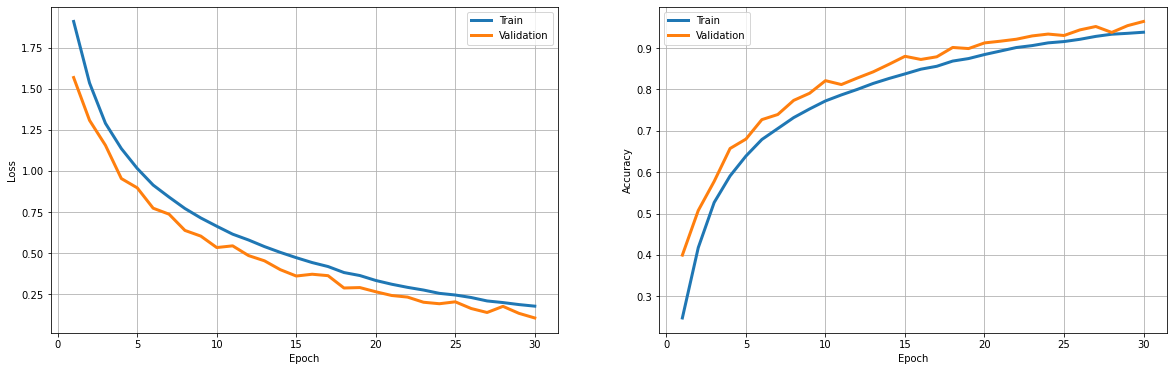

In [60]:
plot_results(N_EPOCHS, train_losses_vgg16_scratch, train_accs_vgg16_scratch, valid_losses_vgg16_scratch, valid_accs_vgg16_scratch)

In [61]:
model_testing(vgg16, test_iterator, criterion, device, 'vgg16.pt')

Test -- Loss: 0.643, Acc: 82.82 %


In [62]:
print_report(vgg16, test_iterator, device)

[[825  14  32  13  15   0   8  10  38  45]
 [  3 924   2   5   2   2   4   0   8  50]
 [ 30   3 754  44  59  25  51  21   7   6]
 [ 14  10  50 624  51 123  57  44   7  20]
 [  7   1  40  28 833  12  29  42   5   3]
 [  5   4  36 122  44 708  22  53   1   5]
 [  2   1  24  24  16   8 917   2   3   3]
 [  5   2  12  29  26  28   2 883   0  13]
 [ 31  22   4   7   3   1   5   2 889  36]
 [ 15  36   3   4   0   1   5   5  11 920]]


              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1000
           1       0.91      0.92      0.92      1000
           2       0.79      0.75      0.77      1000
           3       0.69      0.62      0.66      1000
           4       0.79      0.83      0.81      1000
           5       0.78      0.71      0.74      1000
           6       0.83      0.92      0.87      1000
           7       0.83      0.88      0.86      1000
           8       0.92      0.89      0.90      1000
           9       0.84   

# Transfer Learning


*  Finetuning
*  Feature extraction

In finetuning, we use a pretrained model and update all of its parameters for the new task (**the whole model is retrained**). In feature extraction, we use a pretrained model and only update the final layer(s) weights. In this case, we use a pretrained CNN as a **fixed** feature-extractor, and only change its output layer(s).

Steps for both transfer learning methods:

*  Initialize a pretrained model;
*  Reshape the final layer(s) to match number of outputs and number of classes in the new dataset;
*  Define which parameters we must be updated during training;
*  Train the network.

*  Data normalization

From the PyTorch website (https://pytorch.org/vision/stable/models.html):

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [63]:
# Normalize CIFAR10
mean_imagenet = [0.485, 0.456, 0.406]
std_imagenet = [0.229, 0.224, 0.225]

In [64]:
# Compositions of transformations
train_transforms = torchvision.transforms.Compose([
#                                                   torchvision.transforms.Resize((224,224)),
                                                   torchvision.transforms.RandomCrop(32,5),
                                                   torchvision.transforms.ToTensor(), # values are normalized between 0 and 1
                                                   torchvision.transforms.Normalize(mean_imagenet, std_imagenet)
])

test_transforms = torchvision.transforms.Compose([
 #                                                 torchvision.transforms.Resize((224,224)),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(mean_imagenet, std_imagenet)
])

In [65]:
# Load data with transformations
train_data = torchvision.datasets.CIFAR10(root=ROOT,
                                        train=True,
                                        download=True,
                                        transform=train_transforms)

test_data = torchvision.datasets.CIFAR10(root=ROOT,
                                        train=False,
                                        download=True,
                                        transform=test_transforms)
print(train_data)
print(test_data)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [66]:
valid_data = create_validation_set(train_data, 0.8, test_transforms)

Number training examples: 40000
Number validation examples: 10000


In [67]:
# Create iterators
BATCH_SIZE = 128

train_iterator = torch.utils.data.DataLoader(train_data, 
                                             shuffle=True, 
                                             batch_size=BATCH_SIZE)

valid_iterator = torch.utils.data.DataLoader(valid_data, 
                                             batch_size=BATCH_SIZE)

test_iterator = torch.utils.data.DataLoader(test_data, 
                                            batch_size=BATCH_SIZE)

*  Finetuning

In [68]:
%%capture
vgg16_fine_tuning = torchvision.models.vgg16(pretrained = True) # Load weights

In [69]:
print(vgg16_fine_tuning.classifier[-1])

Linear(in_features=4096, out_features=1000, bias=True)


In [70]:
# Define new output layer
OUTPUT_DIM = 10
vgg16_fine_tuning.classifier[-1] = nn.Linear(vgg16_fine_tuning.classifier[-1].in_features, OUTPUT_DIM)

In [71]:
# Optim
optimizer = optim.Adam(vgg16_fine_tuning.parameters(), lr=1e-4)

vgg16_fine_tuning = vgg16_fine_tuning.to(device)

In [72]:
N_EPOCHS = 30
train_losses_vgg16_fine_tuning, train_accs_vgg16_fine_tuning, valid_losses_vgg16_fine_tuning, valid_accs_vgg16_fine_tuning = model_training(N_EPOCHS, 
                                                                                                                            vgg16_fine_tuning,
                                                                                                                            train_iterator,
                                                                                                                            valid_iterator,
                                                                                                                            optimizer,
                                                                                                                            criterion,
                                                                                                                            device,
                                                                                                                            'vgg16_fine_tuning.pt') 


Epoch: 1/30 -- Epoch Time: 52.79 s
---------------------------------
Train -- Loss: 0.844, Acc: 71.12%
Val -- Loss: 0.509, Acc: 82.69%

Epoch: 2/30 -- Epoch Time: 52.86 s
---------------------------------
Train -- Loss: 0.510, Acc: 82.96%
Val -- Loss: 0.373, Acc: 87.48%

Epoch: 3/30 -- Epoch Time: 52.73 s
---------------------------------
Train -- Loss: 0.396, Acc: 86.86%
Val -- Loss: 0.257, Acc: 91.15%

Epoch: 4/30 -- Epoch Time: 52.77 s
---------------------------------
Train -- Loss: 0.332, Acc: 88.77%
Val -- Loss: 0.241, Acc: 91.79%

Epoch: 5/30 -- Epoch Time: 52.79 s
---------------------------------
Train -- Loss: 0.273, Acc: 90.82%
Val -- Loss: 0.232, Acc: 91.65%

Epoch: 6/30 -- Epoch Time: 52.81 s
---------------------------------
Train -- Loss: 0.232, Acc: 92.09%
Val -- Loss: 0.165, Acc: 94.69%

Epoch: 7/30 -- Epoch Time: 52.70 s
---------------------------------
Train -- Loss: 0.200, Acc: 93.33%
Val -- Loss: 0.124, Acc: 96.04%

Epoch: 8/30 -- Epoch Time: 52.78 s
------------

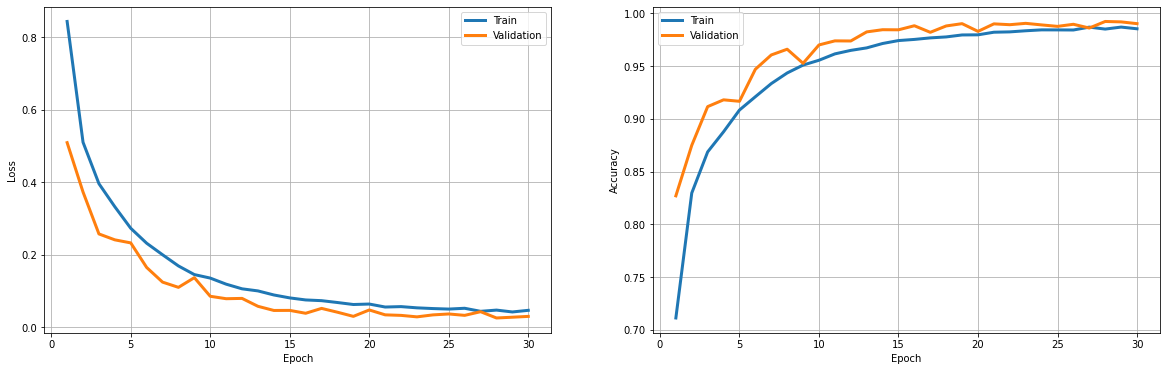

In [73]:
plot_results(N_EPOCHS, train_losses_vgg16_fine_tuning, train_accs_vgg16_fine_tuning, valid_losses_vgg16_fine_tuning, valid_accs_vgg16_fine_tuning)

In [74]:
model_testing(vgg16_fine_tuning, test_iterator, criterion, device, 'vgg16_fine_tuning.pt')

Test -- Loss: 0.475, Acc: 89.68 %


In [75]:
print_report(vgg16_fine_tuning, test_iterator, device)

[[890   3  25   9   7   2   1   5  54   4]
 [  6 915   1   2   0   0   0   0  18  58]
 [ 11   0 914  18  26  13  10   4   4   0]
 [  5   0  47 789  25  91  18  12   9   4]
 [  3   1  39  22 895  10   9  16   4   1]
 [  1   0  15 107  17 831   7  17   2   3]
 [  5   0  43  27  11   4 905   1   2   2]
 [  3   0  21  20  26  16   1 907   5   1]
 [ 12   1   6   1   0   0   0   2 972   6]
 [  9  13   3   6   1   1   1   2  12 952]]


              precision    recall  f1-score   support

           0       0.94      0.89      0.92      1000
           1       0.98      0.92      0.95      1000
           2       0.82      0.91      0.86      1000
           3       0.79      0.79      0.79      1000
           4       0.89      0.90      0.89      1000
           5       0.86      0.83      0.84      1000
           6       0.95      0.91      0.93      1000
           7       0.94      0.91      0.92      1000
           8       0.90      0.97      0.93      1000
           9       0.92   

* Feature extraction


In [76]:
%%capture
vgg16_feat_extract = torchvision.models.vgg16(pretrained = True) # Load weights

In [77]:
OUTPUT_DIM = 10
vgg16_feat_extract.classifier[-1] = nn.Linear(vgg16_feat_extract.classifier[-1].in_features, OUTPUT_DIM)

In [78]:
# Freeze all layers except last FC layer
for parameter in vgg16_feat_extract.features.parameters():
  parameter.requires_grad = False
for parameter in vgg16_feat_extract.classifier[:-1].parameters():
  parameter.requires_grad = False

In [79]:
# Optim
optimizer = optim.Adam(vgg16_feat_extract.parameters(), lr=1e-4)

vgg16_feat_extract = vgg16_feat_extract.to(device)

In [80]:
N_EPOCHS = 30
train_losses_vgg16_feat_extract, train_accs_vgg16_feat_extract, valid_losses_vgg16_feat_extract, valid_accs_vgg16_feat_extract = model_training(N_EPOCHS, 
                                                                                                                            vgg16_feat_extract,
                                                                                                                            train_iterator,
                                                                                                                            valid_iterator,
                                                                                                                            optimizer,
                                                                                                                            criterion,
                                                                                                                            device,
                                                                                                                            'vgg16_feat_extract.pt') 


Epoch: 1/30 -- Epoch Time: 30.51 s
---------------------------------
Train -- Loss: 1.707, Acc: 39.08%
Val -- Loss: 1.319, Acc: 52.93%

Epoch: 2/30 -- Epoch Time: 30.93 s
---------------------------------
Train -- Loss: 1.462, Acc: 47.85%
Val -- Loss: 1.227, Acc: 55.99%

Epoch: 3/30 -- Epoch Time: 33.55 s
---------------------------------
Train -- Loss: 1.397, Acc: 50.20%
Val -- Loss: 1.182, Acc: 57.89%

Epoch: 4/30 -- Epoch Time: 36.63 s
---------------------------------
Train -- Loss: 1.370, Acc: 50.98%
Val -- Loss: 1.151, Acc: 59.14%

Epoch: 5/30 -- Epoch Time: 36.78 s
---------------------------------
Train -- Loss: 1.345, Acc: 52.00%
Val -- Loss: 1.142, Acc: 59.28%

Epoch: 6/30 -- Epoch Time: 36.76 s
---------------------------------
Train -- Loss: 1.328, Acc: 52.53%
Val -- Loss: 1.128, Acc: 60.12%

Epoch: 7/30 -- Epoch Time: 36.68 s
---------------------------------
Train -- Loss: 1.319, Acc: 52.87%
Val -- Loss: 1.119, Acc: 59.93%

Epoch: 8/30 -- Epoch Time: 37.05 s
------------

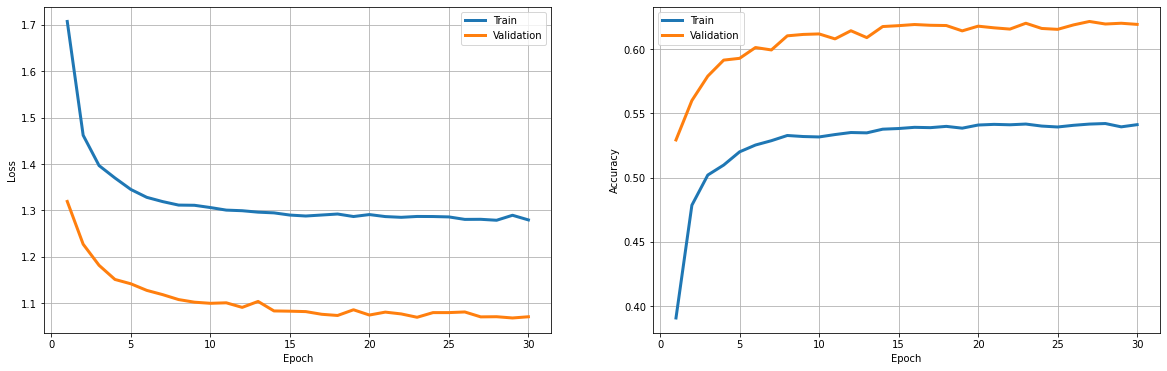

In [81]:
plot_results(N_EPOCHS, train_losses_vgg16_feat_extract, train_accs_vgg16_feat_extract, valid_losses_vgg16_feat_extract, valid_accs_vgg16_feat_extract)

In [82]:
model_testing(vgg16_feat_extract, test_iterator, criterion, device, 'vgg16_feat_extract.pt')

Test -- Loss: 1.112, Acc: 60.93 %


In [83]:
print_report(vgg16_feat_extract, test_iterator, device)

[[696  42  48  11  10   6  21  38  93  35]
 [ 31 798  10   7   3  13  11  10  32  85]
 [ 99  17 501  34  71  54 144  68   7   5]
 [ 29  59  66 356  32 218 136  68  17  19]
 [ 44   5 120  29 402  39 190 163   7   1]
 [ 13  19  79  81  25 643  44  85   5   6]
 [  9   9  69  46  27  48 763  23   6   0]
 [ 35  24  45  35  31  71  25 709   6  19]
 [143  77  30  18   6   6  11  13 644  52]
 [ 57 248   4   7   3   8   6  31  57 579]]


              precision    recall  f1-score   support

           0       0.60      0.70      0.65      1000
           1       0.61      0.80      0.69      1000
           2       0.52      0.50      0.51      1000
           3       0.57      0.36      0.44      1000
           4       0.66      0.40      0.50      1000
           5       0.58      0.64      0.61      1000
           6       0.56      0.76      0.65      1000
           7       0.59      0.71      0.64      1000
           8       0.74      0.64      0.69      1000
           9       0.72   

(None, Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy'))

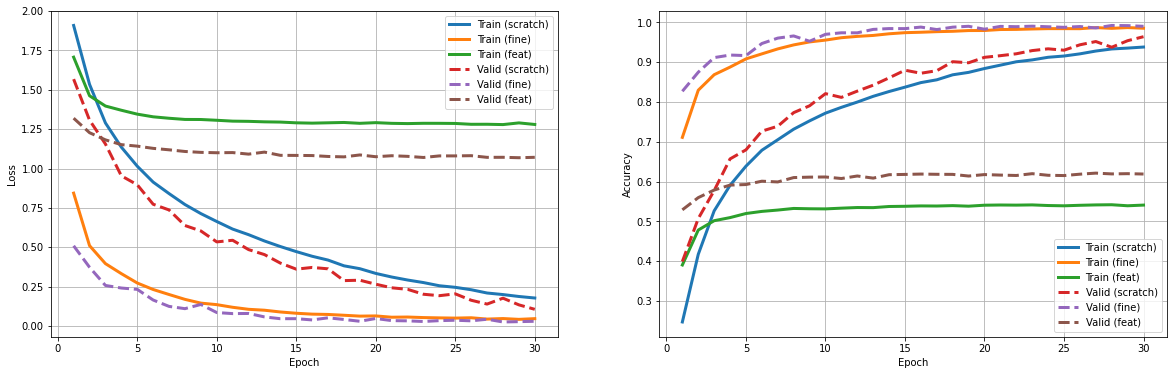

In [84]:
# Plot all results
plt.figure(figsize=(20, 6))
_ = plt.subplot(1,2,1)
plt.plot(np.arange(N_EPOCHS)+1, train_losses_vgg16_scratch, linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, train_losses_vgg16_fine_tuning, linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, train_losses_vgg16_feat_extract, linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, valid_losses_vgg16_scratch, '--', linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, valid_losses_vgg16_fine_tuning, '--', linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, valid_losses_vgg16_feat_extract, '--', linewidth=3)
_ = plt.legend(['Train (scratch)', 'Train (fine)', 'Train (feat)', 'Valid (scratch)', 'Valid (fine)', 'Valid (feat)'])
plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')

_ = plt.subplot(1,2,2)
plt.plot(np.arange(N_EPOCHS)+1, train_accs_vgg16_scratch, linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, train_accs_vgg16_fine_tuning, linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, train_accs_vgg16_feat_extract, linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, valid_accs_vgg16_scratch, '--', linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, valid_accs_vgg16_fine_tuning, '--', linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, valid_accs_vgg16_feat_extract, '--', linewidth=3)
_ = plt.legend(['Train (scratch)', 'Train (fine)', 'Train (feat)', 'Valid (scratch)', 'Valid (fine)', 'Valid (feat)'])
plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')

# **Ex. 4**

Improve the performance of the previous networks or design a new architecture and set the corresponding hyper-parameters in order to achieve better performance on the test set. Some parameters to focus on are listed below:

#### *Network's parameters*:

- Number of layers;
- Number of neurons per layer;
- Activation functions;
- Weights initialization;
- Dropout Rate.

#### *Training parameters*:
- Learning rate;
- Number of epochs;
- Optimizer.

#### *Data*:
- Data augmentation.

#### *Pretrained network*:
- Use different pre-trained networks.